Introduction
============

In most presentations of Riemannian geometry, e.g. @o1983semi and
[Wikipedia](https://en.wikipedia.org/wiki/Fundamental_theorem_of_Riemannian_geometry),
the fundamental theorem of Riemannian geometry ("the miracle of
Riemannian geometry") is given: that for any semi-Riemannian manifold
there is a unique torsion-free metric connection. I assume partly
because of this and partly because the major application of Riemannian
geometry is General Relativity, connections with torsion are given
little if any attention.

It turns out we are all very familiar with a connection with torsion:
the Mercator projection. Some mathematical physics texts,
e.g. @Nakahara2003, allude to this but leave the details to the
reader. Moreover, this connection respects the metric induced from
Euclidean space.

We use [SageManifolds](http://sagemanifolds.obspm.fr) to assist with
the calculations. We hint at how this might be done more slickly in
[Haskell](https://www.haskell.org).

Conformal transaformations also? Koszul formula?

Colophon
--------

This is written as an [Jupyter](http://jupyter.org) notebook. In
theory, it should be possible to run it assuming you have installed at
least sage and Haskell. To publish it, I used

    jupyter-nbconvert --to markdown Mercator.ipynb
    pandoc -s Mercator.md -t markdown+lhs -o Mercator.lhs \
           --filter pandoc-citeproc --bibliography DiffGeom.bib
    BlogLiteratelyD --wplatex Mercator.lhs > Mercator.html

Not brilliant but good enough.

A Cartographic Aside
--------------------

In [1]:
%matplotlib inline

/Applications/SageMath/local/lib/python2.7/site-packages/traitlets/traitlets.py:770: DeprecationWarning: A parent of InlineBackend._config_changed has adopted the new @observe(change) API
  clsname, change_or_name), DeprecationWarning)


In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

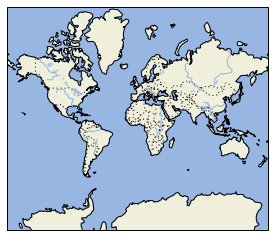

In [4]:
ax = plt.axes(projection=cartopy.crs.Mercator())

ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)

plt.show()


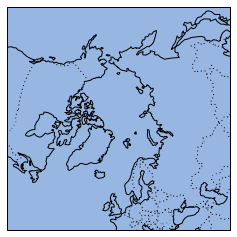

In [7]:
bx = plt.axes(projection=cartopy.crs.NorthPolarStereo())

bx.add_feature(cartopy.feature.LAND)
bx.add_feature(cartopy.feature.OCEAN)
bx.add_feature(cartopy.feature.COASTLINE)
bx.add_feature(cartopy.feature.BORDERS, linestyle=':')
bx.add_feature(cartopy.feature.LAKES, alpha=0.5)
bx.add_feature(cartopy.feature.RIVERS)

bx.set_extent([-180, 180, 45, 90], ccrs.PlateCarree())

plt.show()


In [30]:
%display latex

In [8]:
viewer3D = 'tachyon'

Warming Up With SageManifolds
=============================

Let us try a simple exercise: finding the connection coefficients of
the Levi-Civita connection for the Euclidean metric on $\mathbb{R}^2$
in polar co-ordinates.

Define the manifold.

In [9]:
N = Manifold(2, 'N',r'\mathcal{N}', start_index=1)

Define a chart and frame with Cartesian co-ordinates.

In [10]:
ChartCartesianN.<x,y> = N.chart()

In [11]:
FrameCartesianN = ChartCartesianN.frame()

Define a chart and frame with polar co-ordinates.

In [12]:
ChartPolarN.<r,theta> = N.chart()

In [13]:
FramePolarN = ChartPolarN.frame()

The standard transformation from Cartesian to polar co-ordinates.

In [14]:
cartesianToPolar = ChartCartesianN.transition_map(ChartPolarN, (sqrt(x^2 + y^2), arctan(y/x)))

In [15]:
print(cartesianToPolar)

Change of coordinates from Chart (N, (x, y)) to Chart (N, (r, theta))


In [16]:
cartesianToPolar.display()

text/plainr = sqrt(x^2 + y^2)
theta = arctan(y/x)

In [17]:
cartesianToPolar.set_inverse(r * cos(theta), r * sin(theta))

Check of the inverse coordinate transformation:
   x == x
   y == y
   r == abs(r)
   theta == arctan(sin(theta)/cos(theta))


Now we define the metric to make the manifold Euclidean.

In [18]:
g_e = N.metric('g_e')

In [19]:
g_e[1,1], g_e[2,2] = 1, 1

We can display this in Cartesian co-ordinates.

In [20]:
g_e.display(FrameCartesianN)


text/plaing_e = dx*dx + dy*dy

And we can display it in polar co-ordinates

In [21]:
g_e.display(FramePolarN)

text/plaing_e = dr*dr + (x^2 + y^2) dtheta*dtheta

In [22]:
# Remove me before publishing
print(g_e.display(FramePolarN))

g_e = dr*dr + (x^2 + y^2) dtheta*dtheta


Next let us compute the Levi-Civita connection from this metric.

In [23]:
nab_e = g_e.connection()


In [24]:
nab_e


text/plainLevi-Civita connection nabla_g_e associated with the Riemannian metric g_e on the 2-dimensional differentiable manifold N

If we use Cartesian co-ordinates, we expect that $\Gamma^k_{ij} = 0,
\forall i,j,k$. Only non-zero entries get printed.

In [25]:
nab_e.display(FrameCartesianN)

text/plain

Just to be sure, we can print out all the entries.

In [26]:
nab_e[:]

text/plain[[[0, 0], [0, 0]], [[0, 0], [0, 0]]]

In polar co-ordinates, we get

In [27]:
nab_e.display(FramePolarN)

text/plainGam^r_theta,theta = -sqrt(x^2 + y^2) 
Gam^theta_r,theta = 1/sqrt(x^2 + y^2) 
Gam^theta_theta,r = 1/sqrt(x^2 + y^2)

Which we can rew-rewrite as

$$
\begin{aligned}
\Gamma^r_{\theta,\theta} &= -r \\
\Gamma^\theta_{r,\theta} &= 1/r \\
\Gamma^\theta_{\theta,r} &= 1/r
\end{aligned}
$$

with all other entries being 0.

The Sphere
==========

We define a 2 dimensional manifold. We call it the 2-dimensional
sphere but it we are going to remove a meridian to allow us to define
the desired connection with torsion on it.

In [28]:
S2 = Manifold(2, 'S^2', latex_name=r'\mathbb{S}^2', start_index=1)

In [29]:
S2

text/plain2-dimensional differentiable manifold S^2

To start off with we cover the manifold with two charts.

In [30]:
polar.<th,ph> = S2.chart(r'th:(0,pi):\theta ph:(0,2*pi):\phi'); polar

text/plainChart (S^2, (th, ph))

In [31]:
mercator.<xi,ze> = S2.chart(r'xi:(-oo,oo):\xi ze:(0,2*pi):\zeta'); mercator

text/plainChart (S^2, (xi, ze))

We now have two charts.

In [32]:
S2.atlas()

text/plain[Chart (S^2, (th, ph)), Chart (S^2, (xi, ze))]

In [33]:
epolar = polar.frame(); epolar

text/plainCoordinate frame (S^2, (d/dth,d/dph))

In [34]:
emercator = mercator.frame(); emercator

text/plainCoordinate frame (S^2, (d/dxi,d/dze))

In [35]:
xy_to_uv = polar.transition_map(mercator, (log(tan(th/2)), ph))

In [36]:
xy_to_uv.set_inverse(2*arctan(exp(xi)), ze)

Check of the inverse coordinate transformation:
   th == 2*arctan(sin(1/2*th)/cos(1/2*th))
   ph == ph
   xi == xi
   ze == ze


In [37]:
S2.atlas()

text/plain[Chart (S^2, (th, ph)), Chart (S^2, (xi, ze))]

In [38]:
g = S2.metric('g')

In [39]:
g[1,1], g[2,2] = 1, (sin(th))^2

In [40]:
nab_g = g.connection()

In [41]:
nab = S2.affine_connection('nabla', latex_name=r'\nabla')

In [42]:
ch_basis = S2.automorphism_field()
ch_basis[1,1], ch_basis[2,2] = 1, sin(th)

In [43]:
e = S2.default_frame().new_frame(ch_basis, 'e')

In [44]:
nab.add_coef(e)

text/plain3-indices components w.r.t. Vector frame (S^2, (e_1,e_2))

In [45]:
nab.display(e)

text/plain

In [46]:
nab.display(epolar)

text/plainGam^ph_ph,th = -cos(th)/sin(th)

The equations for geodesics are
$$
\ddot{\gamma}^k_{ij} + \Gamma_{ \phantom{\, {\phi} } \, {\phi} \, {\theta} }^{ \, {\phi} \phantom{\, {\phi} } \phantom{\, {\theta} } }\dot{\gamma}^i\dot{\gamma}^j
$$

In [47]:
R3 = Manifold(3, 'R^3', r'\mathbb{R}^3', start_index=1)

In [48]:
cart.<X,Y,Z> = R3.chart(); cart

text/plainChart (R^3, (X, Y, Z))

In [49]:
Phi = S2.diff_map(R3, {
    (polar, cart): [sin(th) * cos(ph), sin(th) * sin(ph), cos(th)],
    (mercator, cart): [cos(ze) / cosh(xi), sin(ze) / cosh(xi),
                       sinh(xi) / cosh(xi)]
},
    name='Phi', latex_name=r'\Phi')

In [50]:
graph_polar = polar.plot(chart=cart, mapping=Phi, nb_values=11, color='blue')


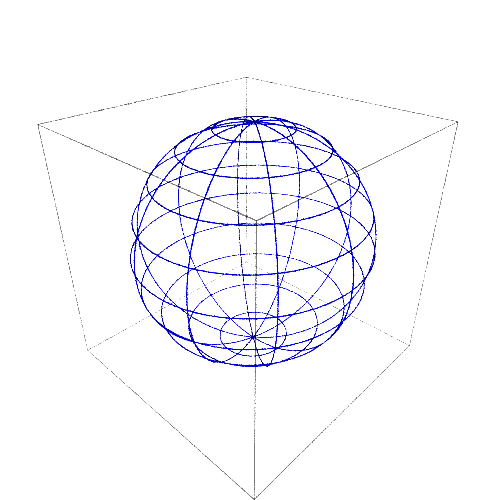

In [51]:
show(graph_polar, viewer=viewer3D)

In [110]:
graph_mercator = mercator.plot(chart=cart, mapping=Phi, nb_values=25, color='red')

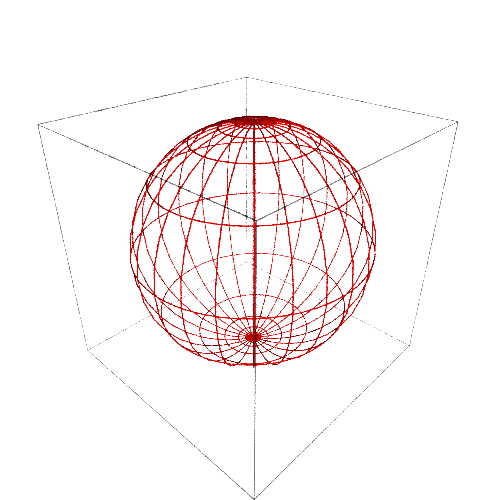

In [111]:
show(graph_mercator, viewer=viewer3D)

In [112]:
R.<t> = RealLine() ; print(R)

Real number line R


In [113]:
print(dim(R))

1


In [114]:
c = S2.curve({polar: [2*atan(exp(-t/10)), t]}, (t, -oo, +oo), name='c')

In [115]:
c.parent()

Set of Morphisms from Real number line R to 2-dimensional differentiable manifold S^2 in Category of smooth manifolds over Real Field with 53 bits of precision

In [116]:
c.display()

c: R --> S^2
   t |--> (th, ph) = (2*arctan(e^(-1/10*t)), t)
   t |--> (xi, ze) = (-1/10*t, t)

In [117]:
graph_c = c.plot(mapping=Phi, max_range=40, plot_points=200, thickness=2)

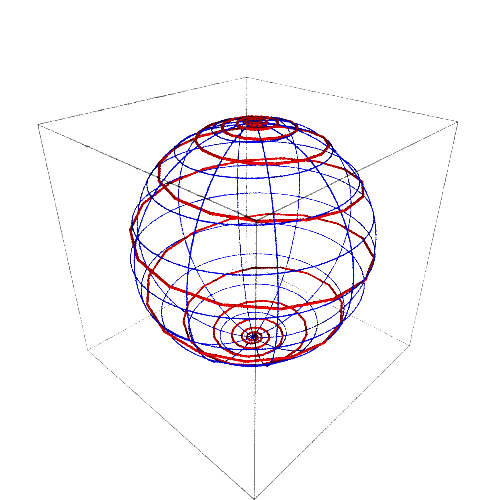

In [118]:
show(graph_polar + graph_c, viewer=viewer3D)

In [119]:
d = S2.curve({polar: [2*atan(exp(-t/4)), t]}, (t, -oo, +oo), name='c')

In [120]:
d.plot(chart=polar, aspect_ratio=0.2)

Graphics object consisting of 1 graphics primitive

In [121]:
graph_d = d.plot(mapping=Phi, max_range=40, plot_points=200, thickness=2, color="green")

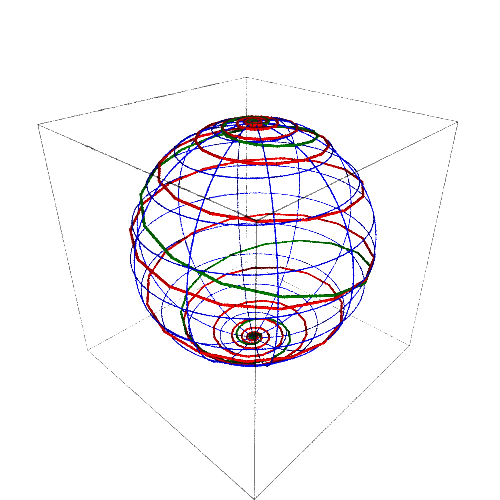

In [122]:
show(graph_polar + graph_c + graph_d, viewer=viewer3D)

In [123]:
d.plot(chart=mercator, aspect_ratio=0.3)

Graphics object consisting of 1 graphics primitive

The **Koszul formula** (see e.g. [@o1983semi]) characterizes the
Levi-Civita connection $\nabla$

$$
\begin{align}
2  \langle \nabla_X Y, Z\rangle & = X  \langle Y,Z\rangle + Y  \langle Z,X\rangle - Z  \langle X,Y\rangle \\
&-  \langle X,[Y,Z]\rangle +   \langle Y,[Z,X]\rangle +  \langle Z,[X,Y]\rangle
\end{align}
$$

Being more explicit about the metric, this can be re-written as

$$
\begin{align}
2 g(\nabla^g_X Y, Z) & = X g(Y,Z) + Y g(Z,X) - Z g(X,Y) \\
&- g(X,[Y,Z]) +  g(Y,[Z,X]) + g(Z,[X,Y])
\end{align}
$$

Let $\nabla^\tilde{g}$ be the Levi-Civita connection for the metric
$\tilde{g} = e^{2\sigma}g$ where $\sigma \in C^\infty M$. Following
[Gadea2010] and substituting into the Koszul formula and then applying
the product rule

$$
\begin{align}
2 e^{2 \sigma} g(\nabla^\tilde{g}_X Y, Z) & = X  e^{2 \sigma} g(Y,Z) + Y e^{2 \sigma} g(Z,X) - Z e^{2 \sigma} g(X,Y) \\
& + e^{2 \sigma} g([X,Y],Z]) - e^{2 \sigma} g([Y,Z],X) + e^{2 \sigma} g([Z,X],Y) \\
& = 2 e^{2\sigma}[g(\nabla^{g}_X Y, Z) + X\sigma g(Y,Z) + Y\sigma g(Z,X) - Z\sigma g(X,Y)] \\
& = 2 e^{2\sigma}[g(\nabla^{g}_X Y + X\sigma Y + Y\sigma X - g(X,Y) \operatorname{grad}\sigma, Z)]
\end{align}
$$

Where as usual the vector field, $\operatorname{grad}\phi$ for $\phi
\in C^\infty M$, is defined via $g(\operatorname{grad}\phi, X) =
\mathrm{d}\phi(X) = X\phi$.

In [74]:
nab_tilde = A.affine_connection('nabla_t', r'\tilde_{\nabla}')

In [78]:
f = A.scalar_field(-ln(sin(th)), name='f')

In [79]:
for i in S2.irange():
    for j in S2.irange():
        for k in S2.irange():
            nab_tilde.add_coef()[k,i,j] = \
                nab_g(spher.frame()[i])(spher.frame()[j])(spher.coframe()[k]) + \
                spher.frame()[i](f) * spher.frame()[j](spher.coframe()[k]) + \
                spher.frame()[j](f) * spher.frame()[i](spher.coframe()[k]) + \
                g(spher.frame()[i], spher.frame()[j]) * spher.frame()[1](spher.coframe()[k]) * cos(th) / sin(th)

In [80]:
nab_tilde.display()

text/plainGam^th_th,th = -cos(th)/sin(th) 
Gam^ph_ph,th = (sqrt(cos(th) + 1)*sqrt(-cos(th) + 1)*cos(th) - cos(th)*sin(th))/sin(th)^2

In [90]:
print(nab_tilde.torsion().display())

(sqrt(cos(th) + 1)*sqrt(-cos(th) + 1)*cos(th) - cos(th)*sin(th))/sin(th)^2 d/dph*dth*dph - (sqrt(cos(th) + 1)*sqrt(-cos(th) + 1)*cos(th) - cos(th)*sin(th))/sin(th)^2 d/dph*dph*dth


Further Reading
===============
More details can be found in:

 * @Agricola2004

References
==========